# Summary
For the given task I have used already a pre-trained model trained on Twitter dataset and predicted sentiment but those sentiments are different from task given classes, but this model is still better than training from scratch.
* dataset is imbalance. few class have a very small instance(Angry & Disgusted & happy , sad) and few class have high instances like Curious to dive deeper.
* i have split dataset into train(90%) , val(5%) and test(5%).
* i have trained model for 30 epochs (it can be trained more but unable to do due to gpu constraints).
* i have use a classification matrix and confusion matrix to get the performance of model 
* we result we can see these classes (Angry & Disgusted & happy , sad) have less accuracy because these classes have fewer data in training.

we can improve the performance of model by doing this
* Doing augmentation like back-translation, and synonym augmentation and we can also use LLM for more data generation
* can do more hyperparameters
given time and GPU constraints we can easily improve accuracy of model.

In [1]:
import os
os.system("pip install transformers -q")
os.system("pip install accelerate -q")

from accelerate import Accelerator
import torch
import torch.nn as nn
import torch.optim as optim

import transformers
from transformers import AdamW
from torch.cuda.amp import autocast , GradScaler
from transformers import get_cosine_schedule_with_warmup , get_cosine_with_hard_restarts_schedule_with_warmup , get_linear_schedule_with_warmup
from transformers import AutoModel , AutoTokenizer
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
df = pd.read_csv("/kaggle/input/splore-dataset/topical_chat.csv - Sheet1.csv")

In [3]:
ls

__notebook_source__.ipynb


In [3]:
df.head()

,conversation_id,message,sentiment
0,1,Are you a fan of Google or Microsoft?,Curious to dive deeper
1,1,Both are excellent technology they are helpful...,Curious to dive deeper
2,1,"I'm not a huge fan of Google, but I use it a...",Curious to dive deeper
3,1,Google provides online related services and p...,Curious to dive deeper
4,1,"Yeah, their services are good. I'm just not a...",Curious to dive deeper


In [4]:
cv = df['conversation_id'].value_counts()
value_dict = sorted(cv.to_dict().items() ,key =  lambda x: x[0])


In [5]:
ids = [ i for i, j in value_dict]
value = [ j for i, j in value_dict]

print("maximum conversation length" , max(value))
print("minimum conversation length" , min(value))

print("average conversation len" , sum(value) / len(value))

maximum conversation length 53
minimum conversation length 20
average conversation len 21.833333333333332


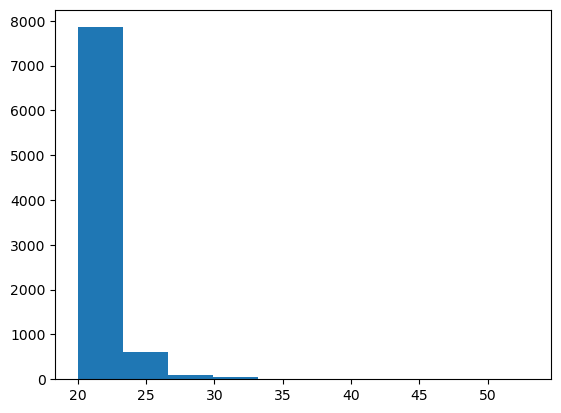

In [6]:
plt.hist(value , bins = 10)
plt.show()

In [7]:
cv = df['sentiment'].value_counts()
value_dict = sorted(cv.to_dict().items() ,key =  lambda x: x[0])
ids = [ i for i, j in value_dict]
value = [ j for i, j in value_dict]

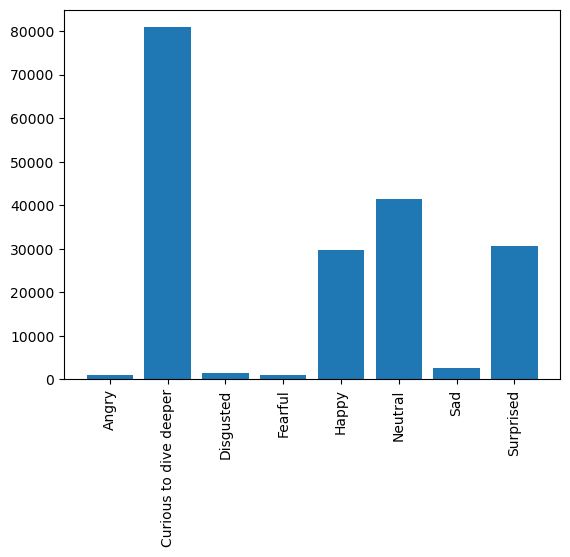

In [8]:
plt.bar(ids,value)
plt.xticks(ids, rotation='vertical')
plt.show()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188378 entries, 0 to 188377
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   conversation_id  188378 non-null  int64 
 1   message          188373 non-null  object
 2   sentiment        188378 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.3+ MB


In [10]:
df[df['message'].isnull()]

,conversation_id,message,sentiment
20124,923,NaN,Disgusted
28552,1306,NaN,Happy
31504,1442,NaN,Surprised
83361,3815,NaN,Curious to dive deeper
95303,4361,NaN,Happy


In [11]:
df = df.dropna()

In [12]:
text_len = df['message'].apply(lambda x : len(x.split(" ")))

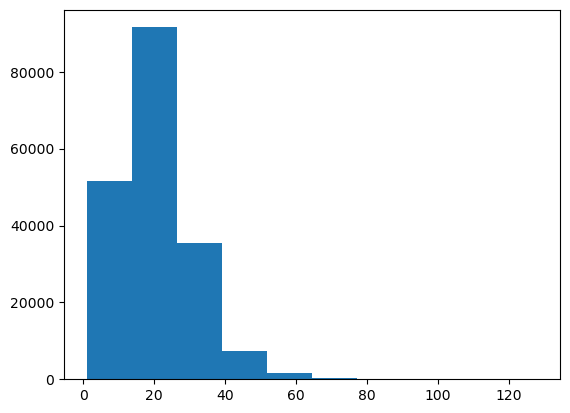

In [13]:
plt.hist(text_len)
plt.show()

data is imbalence 

In [14]:
str2id = {j:i for i ,j in enumerate(ids)}
id2str = {i:j for i ,j in enumerate(ids)}

In [15]:
df['label'] = df['sentiment'].map(str2id)

In [35]:
df.to_csv("proceesed_data.csv" , index=False)

In [16]:
traindf , testdf = train_test_split(df , stratify = df['label'] , test_size = .1)

In [17]:
traindf.head(1)

,conversation_id,message,sentiment,label
113910,5215,"That is true, there is always the risk of a m...",Curious to dive deeper,1


In [18]:
x_train = traindf['message'].values
y_train = traindf['label'].values

x_test = testdf['message'].values
y_test = testdf['label'].values


In [19]:
x_test , x_val ,y_test,y_val = train_test_split(x_test , y_test , test_size =.50 ,stratify = y_test)

In [20]:
print("train_dataset length: " ,len(x_train))
print("test_dataset length: " ,len(x_test))
print("val_dataset length: " ,len(x_val))

train_dataset length:  169535
test_dataset length:  9419
val_dataset length:  9419


In [21]:
import torch.nn as nn
class config:
    SEED = 42
    SAVE_DIR = './output'
    MAX_LEN = 60
    MODEL = 'cardiffnlp/twitter-roberta-base-sentiment-latest' #'microsoft/mdeberta-v3-base'
    EPOCHS = 30
    TRAIN_BATCH_SIZE = 256
    VALID_BATCH_SIZE = 4*4
    TEST_BATCH_SIZE = 4*4
    HIDDEN_SIZE = 768
    NUM_EVAL = 5000
    LR = 5e-6
    WEIGHT_DECAY = 0.1
    NUM_CLASS = 8
    LOSS = nn.CrossEntropyLoss()  

In [22]:
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

In [23]:
def tokenization(text):
    return tokenizer(text , padding = "max_length" , max_length = 60 , truncation = True  )

In [24]:
class Dataset():
    def __init__(self , x,y):
        self.x = x
        self.y =y
        
    def __len__(self):
        return len(self.x)
    def __getitem__(self,idx):
        inputs = tokenization(self.x[idx])
        
        return {
            "ids": torch.tensor(inputs['input_ids']),
            "mask": torch.tensor(inputs['attention_mask']),
            "label" : torch.tensor(self.y[idx])
        }


In [25]:
train_dataset = Dataset(x_train,y_train)
val_dataset = Dataset(x_val ,y_val)
test_dataset = Dataset(x_test ,y_test)


In [26]:
train_dataloader = torch.utils.data.DataLoader(train_dataset , batch_size = config.TRAIN_BATCH_SIZE, drop_last = True)
val_dataloader = torch.utils.data.DataLoader(val_dataset , batch_size = config.VALID_BATCH_SIZE, drop_last = True)
test_dataloader = torch.utils.data.DataLoader(test_dataset , batch_size = config.TEST_BATCH_SIZE, drop_last = True)

In [29]:
class AverageMeter:

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [27]:

class Head(nn.Module):
    def __init__(self, d0, d1):
        super().__init__()
        self.W = nn.Linear(d0, d1)
        self.V = nn.Linear(d1, config.NUM_CLASS)

    def forward(self, x):
        x = self.W(x)
        x = nn.Tanh()(x)
        x = self.V(x)
        # x = nn.Softmax(dim=1)(x)
        return x

class CustomModel(nn.Module):
    def __init__(self, model_name, config,vocab_sz,):
        super().__init__()
        self.config = config
        self.model_name = model_name
        self.model = transformers.AutoModel.from_pretrained(model_name)

        self.head = Head(config.HIDDEN_SIZE, config.HIDDEN_SIZE)      
    def forward(
        self, input_ids=None,attention_mask=None,):
        outputs = self.model(input_ids,attention_mask=attention_mask,)
        sequence_output = outputs[0][:,0,:]
        out = self.head(sequence_output)
        return out

In [31]:
model=CustomModel(config.MODEL,config,tokenizer.vocab_size)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaModel: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
class Trainer:
    def __init__(self, model, train_data_loader, valid_data_loader, optimizer, accelerator):
        
        model, train_data_loader, valid_data_loader, optimizer = accelerator.prepare(model, train_data_loader, valid_data_loader, optimizer)
        
        self.model = model
        self.train_data_loader = train_data_loader 
        self.valid_data_loader = valid_data_loader 
        self.optimizer = optimizer
        self.device = accelerator.device
        self.accelerator = accelerator
        self.loss_fn = config.LOSS
    
      
        
    def train_eval_fn(self, epoch):
        self.model.train()
        losses = AverageMeter()
        
        para_loader = self.train_data_loader
        tk0 = tqdm(para_loader, total=len(para_loader), disable=not self.accelerator.is_local_main_process)
        best_loss = 9999;
        
        for bi, d in enumerate(tk0):
            
            self.model.zero_grad()
            output = self.model(input_ids=d['ids'], attention_mask=d['mask'])
#             output = torch.permute(output , (0,2,1))
            target = d['label']
#             print(target.size() , output.size())
            loss = self.loss_fn(output, target)
    
            self.accelerator.backward(loss)
            self.optimizer.step()

            losses.update(loss.item(), target.size(0))
            tk0.set_postfix(loss=losses.avg)
     
        valid_loss, valid_acc = self.eval_fn()
        if(best_loss > valid_loss):
            unwrapped_model = self.accelerator.unwrap_model(model)
            self.accelerator.save(unwrapped_model.state_dict(), "./output/model.bin")
            best_loss = valid_loss

        print(f'Epoch : {epoch + 1} | Validation loss : {valid_loss}')
        print(f'Epoch : {epoch + 1} | Validation acc : {valid_acc}')
        self.accelerator.wait_for_everyone()
            
    def eval_fn(self):
        self.model.eval()
        losses = AverageMeter()
        acc = AverageMeter()
        
        para_loader = self.valid_data_loader
        
        tk0 = tqdm(para_loader, total=len(para_loader), leave=True, disable=not self.accelerator.is_local_main_process)
        yt, yp = [], []

        with torch.no_grad():
            for bi, d in enumerate(tk0):
                ids = d['ids']
                mask = d['mask']
                target = d['label']
                output = self.model(input_ids=ids, attention_mask=mask)
#                 output = torch.permute(output , (0,2,1))
                
                loss = self.loss_fn(output, target)
                output = torch.sigmoid(output)
                yt = target.cpu().numpy()
                yp = output.detach().cpu().numpy()
                yp = np.argmax(yp , axis = -1)
                losses.update(loss.item(), ids.size(0))
                
                accuracy = np.sum(yt == yp)/ids.size(0)
                acc.update(accuracy , ids.size(0))
               
                tk0.set_postfix(loss=losses.avg)

        return losses.avg, acc.avg

In [ ]:
import numpy as np
def run():  

 
    tokenizer = transformers.AutoTokenizer.from_pretrained(config.MODEL)
    tokenizer.save_pretrained(config.SAVE_DIR)
    
    optimizer = AdamW(model.parameters(), lr=config.LR)

    accelerator = Accelerator()
    
    trainer_obj = Trainer(model, train_dataloader, val_dataloader, optimizer, accelerator)

    accelerator.print('Starting training....')

    for epoch in range(config.EPOCHS):
        trainer_obj.train_eval_fn(epoch)

In [ ]:
run()

In [28]:
model=CustomModel(config.MODEL,config,tokenizer.vocab_size)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaModel: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [29]:
model.load_state_dict(torch.load("/kaggle/input/sentiment-analysis/output/model.bin"))

<All keys matched successfully>

In [41]:
device = "cuda" if torch.cuda.is_available() else "cpu"
class_name = list(str2id.keys())
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def infer(dataloader,model , tokenizer , ):
    
    y_true = []
    y_pred=[]
    model.to(device)
    with torch.no_grad():
        for d in tqdm(dataloader):
            ids = d['ids'].to(device)
            mask = d['mask'].to(device)
            target = d['label'].to(device)
            output = model(input_ids=ids, attention_mask=mask)
            yt = target.cpu().numpy()
            y_true.extend(yt)
            yp = output.detach().cpu().numpy()
            yp = np.argmax(yp , axis = -1)
            y_pred.extend(yp)
    print(classification_report(y_true, y_pred , target_names = class_name))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=class_name)
    disp.plot()
    plt.show()
    return y_pred


100%|██████████| 662/662 [05:29<00:00,  2.01it/s]


                        precision    recall  f1-score   support

                 Angry       0.64      0.52      0.58       789
Curious to dive deeper       0.91      0.91      0.91     72768
             Disgusted       0.67      0.67      0.67      1289
               Fearful       0.78      0.76      0.77       922
                 Happy       0.79      0.88      0.83     26642
               Neutral       0.90      0.85      0.88     37214
                   Sad       0.79      0.82      0.80      2280
             Surprised       0.84      0.82      0.83     27568

              accuracy                           0.87    169472
             macro avg       0.79      0.78      0.78    169472
          weighted avg       0.87      0.87      0.87    169472



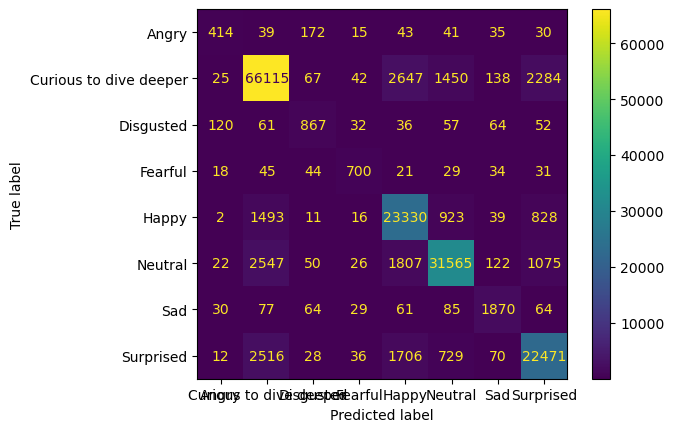

In [34]:
infer(train_dataloader , model,tokenizer)

100%|██████████| 588/588 [00:21<00:00, 27.48it/s]


                        precision    recall  f1-score   support

                 Angry       0.61      0.52      0.56        44
Curious to dive deeper       0.91      0.91      0.91      4042
             Disgusted       0.61      0.63      0.62        71
               Fearful       0.81      0.84      0.83        51
                 Happy       0.80      0.88      0.84      1480
               Neutral       0.91      0.85      0.88      2063
                   Sad       0.73      0.80      0.76       127
             Surprised       0.84      0.83      0.84      1530

              accuracy                           0.87      9408
             macro avg       0.78      0.78      0.78      9408
          weighted avg       0.87      0.87      0.87      9408



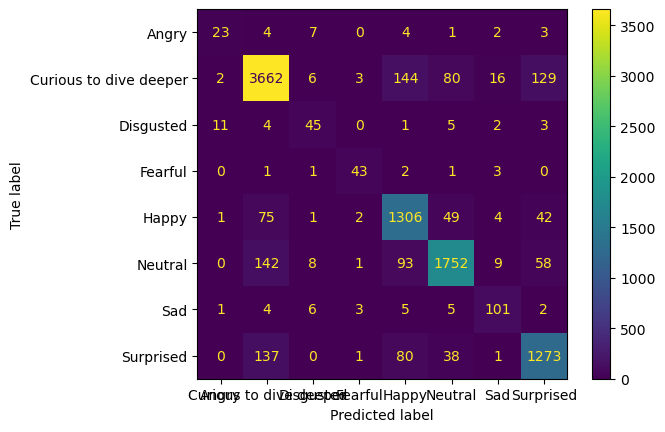

In [32]:
infer(val_dataloader , model,tokenizer)

100%|██████████| 588/588 [00:21<00:00, 27.80it/s]


                        precision    recall  f1-score   support

                 Angry       0.56      0.51      0.54        43
Curious to dive deeper       0.90      0.91      0.91      4042
             Disgusted       0.66      0.64      0.65        72
               Fearful       0.69      0.73      0.71        52
                 Happy       0.78      0.88      0.83      1479
               Neutral       0.90      0.85      0.87      2068
                   Sad       0.84      0.82      0.83       125
             Surprised       0.84      0.81      0.83      1527

              accuracy                           0.87      9408
             macro avg       0.77      0.77      0.77      9408
          weighted avg       0.87      0.87      0.87      9408



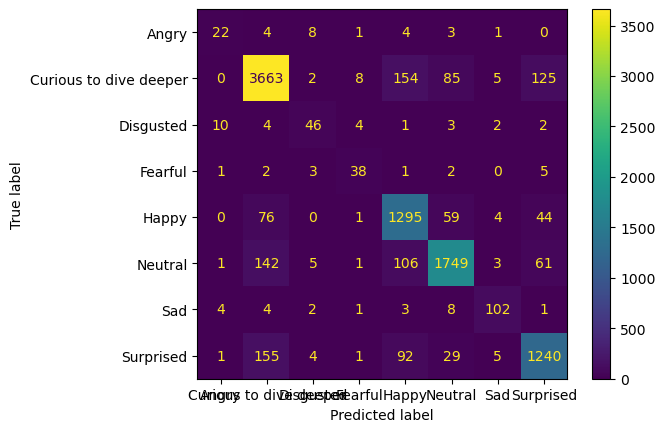

In [33]:
infer(test_dataloader , model,tokenizer)

In [36]:
df_full = pd.read_csv("/kaggle/working/proceesed_data.csv")

In [38]:
X = df_full['message'].values.tolist()
Y = df_full['label'].values.tolist()

In [39]:
full_Dataset = Dataset(X,Y)

In [47]:
dataloader = torch.utils.data.DataLoader(full_Dataset , batch_size = config.TRAIN_BATCH_SIZE)

100%|██████████| 736/736 [06:02<00:00,  2.03it/s]


                        precision    recall  f1-score   support

                 Angry       0.64      0.52      0.57       876
Curious to dive deeper       0.91      0.91      0.91     80887
             Disgusted       0.66      0.67      0.67      1432
               Fearful       0.78      0.76      0.77      1026
                 Happy       0.79      0.88      0.83     29615
               Neutral       0.90      0.85      0.88     41367
                   Sad       0.79      0.82      0.80      2533
             Surprised       0.84      0.82      0.83     30637

              accuracy                           0.87    188373
             macro avg       0.79      0.78      0.78    188373
          weighted avg       0.87      0.87      0.87    188373



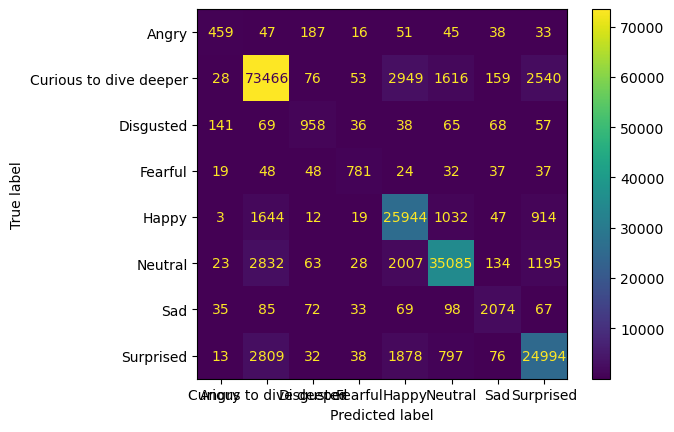

In [48]:
y_pred = infer(dataloader , model,tokenizer)

In [49]:
df_full["prediction"] = y_pred

In [50]:
df_full["prediction"]=df_full["prediction"].map(id2str)

In [51]:
df_full.head(5)

,conversation_id,message,sentiment,label,prediction
0,1,Are you a fan of Google or Microsoft?,Curious to dive deeper,1,Curious to dive deeper
1,1,Both are excellent technology they are helpful...,Curious to dive deeper,1,Happy
2,1,"I'm not a huge fan of Google, but I use it a...",Curious to dive deeper,1,Curious to dive deeper
3,1,Google provides online related services and p...,Curious to dive deeper,1,Curious to dive deeper
4,1,"Yeah, their services are good. I'm just not a...",Curious to dive deeper,1,Curious to dive deeper


In [52]:
df_full.to_csv("full_pred.csv" , index =False)